# Group information

Names: Arthur Dionizio Martins da Silva, Miguel Alessandro Miní Huambachano

RAs: a250814, m176933

## Objective:

To explore **Transfer Learning** techniques, focused on **Transformers**. In this task you'll be visualizing and fine tunning a pre trained transformer to a Natural Language Processing task, specifically, binary sentiment classification.

This **MUST** be developed using the pytorch and the [Hugging Face](https://huggingface.co/) library.

## Dataset

The dataset you will use is the "Large Movie Review Dataset", also known as IMDB dataset. This dataset contains 50000 movie reviews, with positive or negative labels. The dataset is balanced, and the train and test sets are already separated in a disjointed way, to avoid movies being in both datasets (as reviews in the same movies tend to be similar).

The labels are constructed using the ratings of the review, where a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. "Neutral" reviews (score 5 or 6) were ignored, as they cannot be correctly labeled between negative and positive samples.


The dataset will be available in the [same folder](https://drive.google.com/drive/folders/14uiy_7xMq5LOqODBzbIJLD4Vq0E9XD5v) as the other tasks, in the "aclImdb" folder. You can copy the dataset folder or download it locally.

Here are some examples of each class from the dataset:

**Negative**

`Lifetime did it again. Can we say stupid? I couldn't wait for it to end. The plot was senseless. The acting was terrible! Especially by the teenagers. The story has been played a thousand times! Are we just desperate to give actors a job? The previews were attractive and I was really looking for a good thriller.Once in awhile lifetime comes up with a good movie, this isn't one of them. Unless one has nothing else to do I would avoid this one at all cost. This was a waste of two hours of my life. Can I get them back? I would have rather scraped my face against a brick wall for two hours then soaked it in peroxide. That would have been more entertaining.`

**Positive**

`Generally it was a good movie with an ideal ending; the acting was spectacular and the characters didn't stray from their persons. I especially liked the plot, although you knew what was going to happen it still gave the element of surprise through out the entire movie. However, I find that coming on to the ending it could have been a little longer (extended maybe)- to me it seemed like it was rushed a bit; as if the writer was trying to take linens off the lines before the rain fell. For instance- What happened to Tristan's brother, Hayden? For all we know he died in the hospital. Maybe he was the one that setup the entire thing?! Who knows! Maybe there will be a sequel? Maybe? If there is.. I cant wait to see it.`


As in the previous task, in this task the data analysis will not be required. Again, its important to remember that the data analysis is a constant and important part of the machine learning pipeline, and we are just skipping it because this task has educational purposes only.

## Loading the dataset

The code below is already completed to load the dataset separating it in train, validation and test.

In [ ]:
import os
import random
import pandas as pd

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

from transformers import BertTokenizerFast, BertForSequenceClassification

In [ ]:
# Define dataset path (remove colab import/mount if running locally)

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# set path to the folder that contains the aclImdb dataset
path = "gdrive/MyDrive/MC886 - Datasets/"

Mounted at /content/gdrive


In [ ]:
# this separates 20k for training, 5k for validation and 25k for testing

max_valid = 5000

import os
from concurrent.futures import ThreadPoolExecutor

def read_file(path):
    with open(path) as f:
        return f.read()

def load_texts(folder):
    texts = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(read_file, os.path.join(folder, file)) for file in os.listdir(folder) if os.path.isfile(os.path.join(folder, file))]
        for future in futures:
            texts.append(future.result())
    return texts

x_train_pos = load_texts(path + 'aclImdb/train/pos')
x_train_neg = load_texts(path + 'aclImdb/train/neg')
x_test_pos  = load_texts(path + 'aclImdb/test/pos')[:-max_valid * 3 // 2]
x_test_neg  = load_texts(path + 'aclImdb/test/neg')[:-max_valid * 3 // 2]

x_train = x_train_pos + x_train_neg
x_test  = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test  = [True] * len(x_test_pos)  + [False] * len(x_test_neg)

c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

x_valid = x_train[-max_valid:]
y_valid = y_train[-max_valid:]
x_train = x_train[:-max_valid]
y_train = y_train[:-max_valid]

print('\nFirst two train samples:')
for i, (source, target) in enumerate(zip(x_train[:2], y_train[:2])):
  print(f"{i}: Input: {source}\n   Target: {'positive' if target else 'negative'}\n")

print('-'*200)
print('\nFirst two valid samples:')
for i, (source, target) in enumerate(zip(x_valid[:2], y_valid[:2])):
  print(f"{i}: Input: {source}\n   Target: {'positive' if target else 'negative'}\n")

print('-'*200)
print(f'Train size: {len(x_train)}')
print(f'Valid size: {len(x_valid)}')
print(f'Test size: {len(x_test)}')


First two train samples:
0: Input: Ever heard of a taiwanese horror movie? Or any taiwanese movie? Propably for a reason. This one was a really boring one, even though it has black magic including withered baby bodies and people exploding from the inside with thousands of eels.<br /><br />Having read other peoples thoughts, I was looking forward for some violence and gore, but there's not much at all. Some blood puking and other lame stuff, if you are waiting for graphic gore or any gruesome effects you will be disappointed. They clearly didn't use the eel exploding and other things to their maximum potent.<br /><br />Pretty much nothing good about this movie; a single character that wasn't completely bland and a few OK black magic spells, like the eel one. The plot was confusing and boring. The characters were thin and annoying, including the main character. The horror aspect didn't work at all, the most horrifying thing was an albino girl (not that scary really). This is the worst A

We reduce tests for extreme memory consumption.

## Loading the pre trained transformer

The code below loads a pre trained transformer from hugging face library.
The **recommended** model is the BERT-Mini, that is a smaller version of the BERT transformer.

You can choose other transformers to test, but the BERT-Mini was choosed to reduce the fine tunning time, while also having a powerfull structure.

The image below shows the normal BERT architecture scheme and the BERT-Large. In the same way, the BERT-Mini has only four attention heads (instead of the original 12).

![BERTS](https://huggingface.co/blog/assets/52_bert_101/BERT-size-and-architecture.png)

The BERT variations also are related to amount of hidden embedding sizes.
Some variations are:

- google/bert_uncased_L-2_H-128_A-2 (BERT-Tiny, 4M params)
- google/bert_uncased_L-4_H-256_A-4 (BERT-Mini, 11M params)
- google/bert_uncased_L-4_H-512_A-4 (BERT-Small, 29M params)
- google/bert_uncased_L-8_H-512_A-8 (BERT-Medium, 41M params)
- google/bert_uncased_L-12_H-768_A-12 (BERT-Base, 110M params)

You can find more details about miniature BERT versions [here](https://huggingface.co/google/bert_uncased_L-4_H-256_A-4).


## Parameters

In [ ]:
params = {
    'bert_version': "google/bert_uncased_L-4_H-256_A-4",
    'batch_size': 64,
    'learning_rate': 1e-4, # Choose a learning rate between 1e-4 and 1e-7
    'weight_decay': 0.01,  # Choose a value between 1e-2 and 1e-4.
    'max_length': 100,     # The maximum length of the sentence (can be adjusted)
    'epochs': 7,           # Choose a value between 1 and 5
}

## Tokenizer

To use text as input for a deep learning model, we first need to tokenize each sentence based on a set of rules. After tokenization, each token is assigned a correlated index, creating a feature vector. This vector is then utilized by the model to train and update the weights. Here is an example demonstrating how the BERT tokenizer works:

![bert_tokenizer](https://drive.google.com/uc?export=view&id=11LioDFis0JE3ghr672PEIeaAxZO42gUL)

Initially, the input sentence is divided into tokens predetermined by the BERT tokenizer. Next, the BertTokenizer introduces two special tokens: CLS and SEP. CLS represents sentence start for tasks like classification, while SEP indicates sentence separation for boundary detection within a document. Additionally, to ensure sentences are of equal length, the tokenizer employ the PAD token for each input.

Finally, each token is converted into a predetermined index for BERT input. This indexing enables the Bert model to train and update its weights effectively.

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data   = data
        self.labels = torch.Tensor(labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.data.items()}
        item['labels'] = self.labels[index]
        return item

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(params['bert_version'], disable_tqdm=False)

## TOKENIZE
train_encodings = tokenizer(list(x_train), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
valid_encodings = tokenizer(list(x_valid), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
test_encodings  = tokenizer(list(x_test),  truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])

## DATASET
train_dataset = IMDBDataset(data=train_encodings, labels=y_train)
valid_dataset = IMDBDataset(data=valid_encodings, labels=y_valid)
test_dataset  = IMDBDataset(data=test_encodings, labels=y_test)

## DATALOADER
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=1)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=params['batch_size'], num_workers=1)
test_loader  = DataLoader(dataset=test_dataset, batch_size=params['batch_size'], num_workers=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Load the transformer


In [ ]:

#defining device where to to the computation
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained(params['bert_version'], output_hidden_states=True)
model = model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-256_A-4 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Dimentionality reduction and visualization tranformer embeddings (3.5 points)

In this section, you should use PCA and t-SNE to visualize the embeddings produced by the transformer for a batch of the aclImdb dataset.

In [ ]:
# Function to visualize the embeddings

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_layerwise_embeddings(hidden_states, masks, labels, layers_to_visualize, dim_reducer):
    '''
    'hidden_states' are the activations of the hidden layers for a batch
      (use the '.hidden_states' attribute from the transformer's output with 'output_hidden_states=True');
    'masks' are the attention masks of each sample (the dataloader returns a dict with the "attention_masks" key);
    'labels' are the labels of the batch;
    'layers_to_visualize' is an array of indexes to look on 'hidden_states';
    'dim_reducer' is a function to reduce the dimentionality of the hidden states (should be PCA or t-SNE object).
    '''
    num_layers = len(layers_to_visualize)

    fig = plt.figure(figsize=(24, int((num_layers / 4) * 6)))  # each subplot of size 6x6, each row will hold 4 plots
    ax = [fig.add_subplot(num_layers // 4 + 1, 4, i + 1) for i in range(num_layers)]

    labels = labels.cpu().numpy().reshape(-1)

    for i, layer_i in enumerate(layers_to_visualize):
        layer_embeds = hidden_states[layer_i]  # Keep embeddings on GPU

        layer_averaged_hidden_states = torch.div(layer_embeds.sum(dim=1), masks.sum(dim=1, keepdim=True).to(layer_embeds.device))

        layer_dim_reduced_embeds = dim_reducer.fit_transform(layer_averaged_hidden_states.cpu().detach().numpy())

        df = pd.DataFrame.from_dict({'x': layer_dim_reduced_embeds[:, 0], 'y': layer_dim_reduced_embeds[:, 1], 'label': labels})

        sns.scatterplot(data=df, x='x', y='y', hue='label', ax=ax[i], palette='husl')

    plt.show()


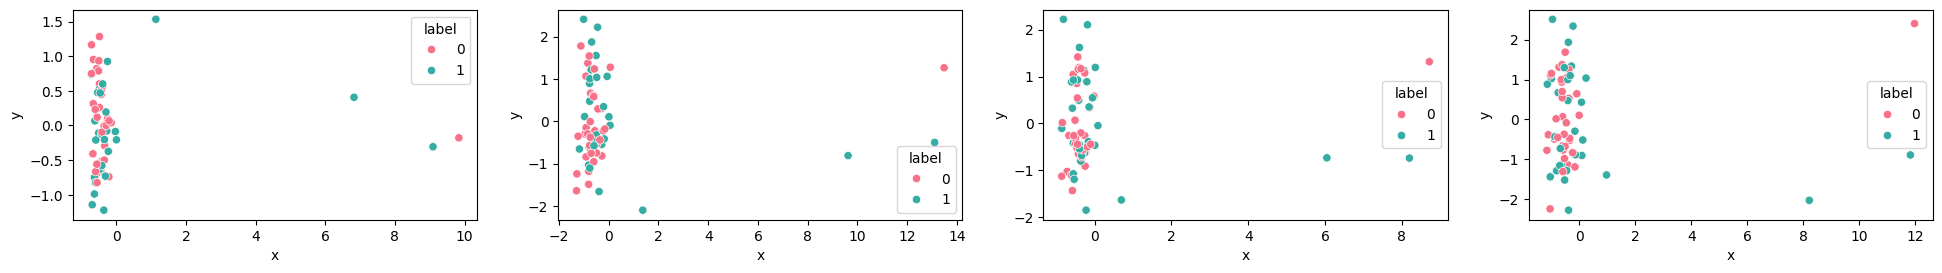

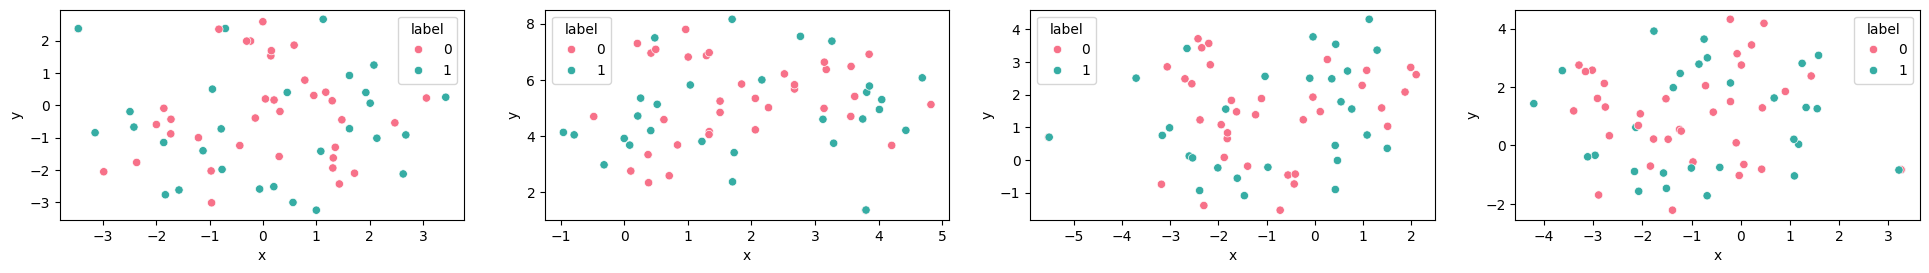

In [ ]:
#get batch states
batch = next(iter(train_loader))
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
labels = batch['labels'].to(device)
#hidden states
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    hidden_states = outputs.hidden_states

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

layers_to_visualize = [0, 1, 2, 3]

# PCA visualization
pca = PCA(n_components=2)
visualize_layerwise_embeddings(hidden_states, attention_mask, labels, layers_to_visualize, pca)
plt.show()

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
visualize_layerwise_embeddings(hidden_states, attention_mask, labels, layers_to_visualize, tsne)
plt.show()



### Discussion of key points

- The PCA and t-SNE had similar results for the visualization of the embeddings?

The results from PCA and t-SNE show some similarity in the separation of classes (labels 0 and 1). Both dimensionality reduction techniques attempt to project the data into a 2D space while preserving the relevant characteristics of high dimensionality.

However, t-SNE tends to be more effective in capturing nonlinear structures and can provide better visual separation between classes, which is evident in the plots. Despite this, the differences may not be drastic depending on the data and the level of complexity of the nonlinear relationships between features.

In the provided plots, it can be seen that in both visualizations, classes 0 and 1 are mixed but there are some visible separations in both techniques, indicating that both are capable of capturing some structure in the data.

- Looking at the best result, this transformer can be used as a Zero-shot* model for this task?


* Zero-shot is the usage a model for a new task without any new traning.


In the visualization, there is some separation between the classes, but there is also considerable overlap. This suggests that while the model has captured some distinctive features of the classes, the separation is not clear enough to rely on the model for accurate classification without additional specific training for the task.

Therefore, based on this visualization, it appears that the transformer may need some additional training (fine-tuning) to improve separation and accuracy in this specific task, rather than being used directly as a Zero-shot model.

## Fine tune the transformer (5.5 points)

In this section you should fine tune the transformer for the sentiment classification task.

To fine tune a model, we need to "freeze" some of their layers. In this case, we will freeze all trainable parameters, except the last part of the model, which is a fully connected layer called "classifier". You can change this approach and test without freezing the entire transformer, but it is not required.

It is important to pay attention to the learning rate and weight decay of the optimizer. Usually, transformers adapt quickly to the problem, and a wrong learning rate (or number of training epochs) can cause an overfitting.

Work with one epoch and smaller batch sizes to test your implementation, as the training can take a longe time.

Remember to test your final model and plot a confusion matrix with the test data.


In [ ]:
# Freeze all layers of the pre trained model
for i,param in enumerate(model.parameters()):
  param.requires_grad = False

# unfreeze classifier (last layer)
model.classifier.weight.requires_grad = True
#model.classifier.bias.requieres_grad = True

In [ ]:
# Define the optmizer, scheduler and criterion

optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay']) # https://pytorch.org/docs/stable/optim.html
# scheduler = # Optional: use a scheduler to control the learning rate (besides the weight_decay of the optimizer)
criterion = torch.nn.CrossEntropyLoss()


### Create the train and validation logic

*Tip: The forward method of the BERT transformer expect the "input_ids" and "attention_masks". You can search about the usage of hugging face transformers on the official documentation [here](https://huggingface.co/docs/transformers/v4.41.3/en/model_doc/bert#transformers.BertForSequenceClassification)*

In [ ]:
def train():
    model.train()
    train_loss = 0
    train_correct = 0
    total = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs.logits, dim=1)
        train_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = train_correct / total
    return train_loss, train_acc

def evaluate():
    model.eval()
    valid_loss = 0
    valid_correct = 0
    total = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

            valid_loss += loss.item()
            _, preds = torch.max(outputs.logits, dim=1)
            valid_correct += (preds == labels).sum().item()
            total += labels.size(0)

    valid_loss /= len(valid_loader)
    valid_acc = valid_correct / total
    return valid_loss, valid_acc

### Train and validate

In [ ]:
history = {'train_loss': [], 'valid_loss': [], 'train_acc':[], 'valid_acc':[]}

for epoch in tqdm(range(params['epochs']), desc='Training'):
  train_loss, train_acc = train()
  valid_loss, valid_acc = evaluate()

  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)

  history['valid_loss'].append(valid_loss)
  history['valid_acc'].append(valid_acc)

Training:   0%|          | 0/7 [00:00<?, ?it/s]

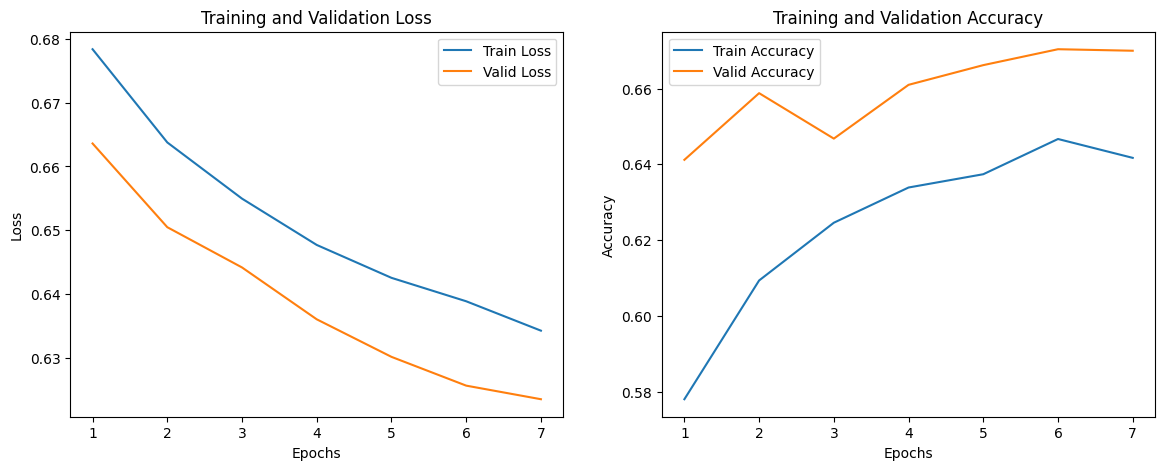

In [ ]:
epochs = range(1, params['epochs'] + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['valid_loss'], label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['valid_acc'], label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
del history

## Visualize transformer embeddings again (1 point)

Use the same logic previously used in the first part of this task to visualize the fine tunned embeddings of the transformer (with PCA and t-SNE).

In [ ]:
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_hidden_states = []
    all_attention_masks = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
            _, preds = torch.max(outputs.logits, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Move tensors to CPU for appending to lists
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_hidden_states.append([state.cpu() for state in outputs.hidden_states])
            all_attention_masks.append(attention_mask.cpu())

    test_acc = correct / total
    return test_acc, all_preds, all_labels, all_hidden_states, all_attention_masks

# Evaluar el modelo en el conjunto de prueba
test_acc, all_preds, all_labels, all_hidden_states, all_attention_masks = test(model, test_loader, device)
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.6573


The result was not very promising; we tried increasing the epochs, but it resulted in overfitting, which caused better performance in training and poor performance in both validation and test sets. In the end, we varied the weight decay and learning rate without apparent improvements.

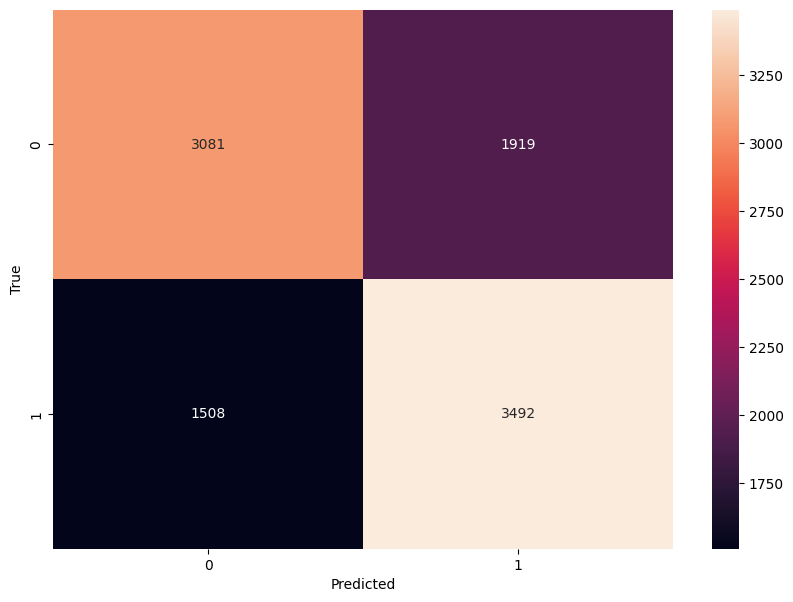

In [ ]:
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(conf_matrix, index=[i for i in "01"], columns=[i for i in "01"])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

We can observe in the confusion matrix that the predictions are balanced with respect to both types of data.

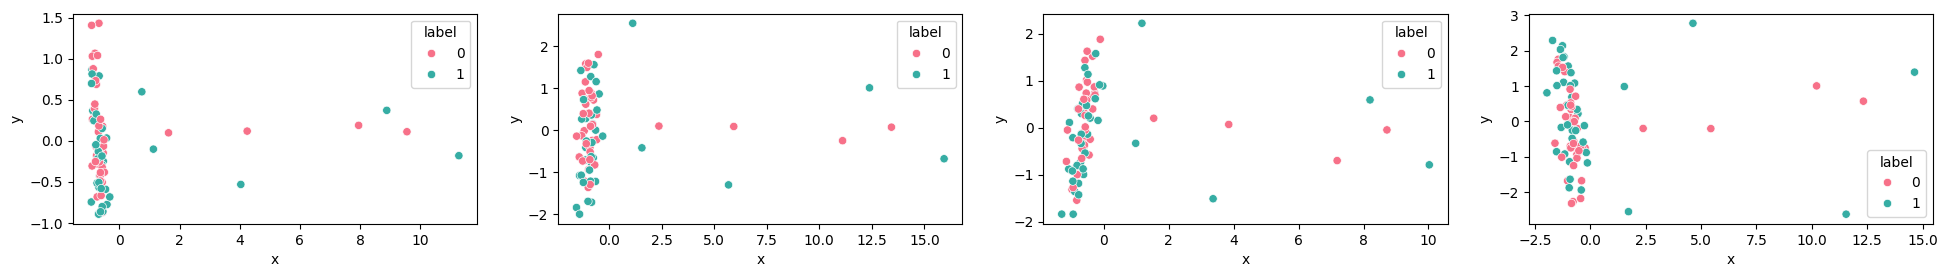

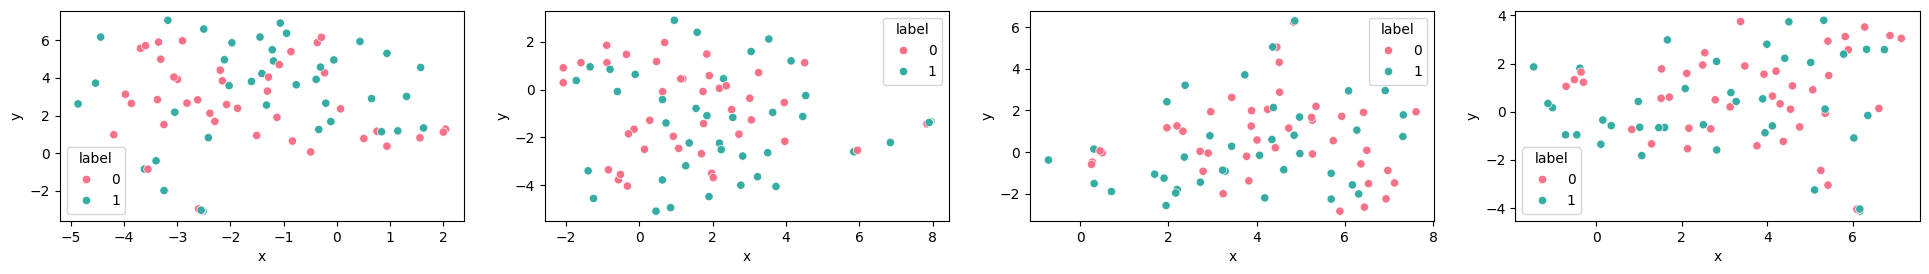

In [ ]:
import numpy as np
num_samples = 80
subset_indices = np.random.choice(len(all_labels), num_samples, replace=False)

def visualize_layerwise_embeddings2(hidden_states, masks, labels, layers_to_visualize, dim_reducer):
    num_layers = len(layers_to_visualize)

    fig = plt.figure(figsize=(24, int((num_layers / 4) * 6)))
    ax = [fig.add_subplot(num_layers // 4 + 1, 4, i + 1) for i in range(num_layers)]

    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy().reshape(-1)
    else:
        labels = labels.reshape(-1)

    if not isinstance(masks, torch.Tensor):
        masks = torch.tensor(masks, device=hidden_states[0].device)

    for i, layer_i in enumerate(layers_to_visualize):
        layer_embeds = hidden_states[layer_i]  # Keep embeddings on GPU
        layer_averaged_hidden_states = torch.div(layer_embeds.sum(dim=1), masks.sum(dim=1, keepdim=True).to(layer_embeds.device))
        layer_dim_reduced_embeds = dim_reducer.fit_transform(layer_averaged_hidden_states.cpu().detach().numpy())

        df = pd.DataFrame.from_dict({'x': layer_dim_reduced_embeds[:, 0], 'y': layer_dim_reduced_embeds[:, 1], 'label': labels})

        sns.scatterplot(data=df, x='x', y='y', hue='label', ax=ax[i], palette='husl')

    plt.show()

# Procesar los estados ocultos para el subconjunto
flattened_hidden_states_subset = [torch.cat([hidden_states[layer].cpu() for hidden_states in all_hidden_states], dim=0)[subset_indices] for layer in range(len(all_hidden_states[0]))]
attention_mask_subset = torch.cat(all_attention_masks).cpu().numpy()[subset_indices]
labels_subset = np.array(all_labels)[subset_indices]

# Visualización con PCA
pca = PCA(n_components=2)
visualize_layerwise_embeddings2(flattened_hidden_states_subset, attention_mask_subset, labels_subset, layers_to_visualize, pca)
plt.show()

# Visualización con t-SNE
tsne = TSNE(n_components=2)
visualize_layerwise_embeddings2(flattened_hidden_states_subset, attention_mask_subset, labels_subset, layers_to_visualize, tsne)
plt.show()

### Discussion of key points

- The fine tunning was able to improve the embedding visualization?


Although the data tells us that the improvement was 30%, there was no visual improvement for the observed layers; in fact, it seems that the data observed by PCA is more mixed in the tests. Nevertheless, we can say that t-SNE tends to form more clustered green points (green on the top / red on the bottom). On the other hand, the number of tests was reduced due to limited RAM memory, although it did not affect the obtained accuracy.

## Deadline

Friday, June 28, 11:59 pm.

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- June 29, 11:59 pm : grade * 0.75
- June 30, 11:59 pm : grade * 0.5
- July 01, 11:59 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English) or Google Colaboratory link (remember to share it!).

**This activity is NOT individual, it must be done in pairs (two-person group).**

Only one individual should deliver the notebook.